In [7]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [10]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()
df_DA_US = df_DA_US.dropna(subset = ['salary_year_avg'])

In [11]:
df_DA_US_exploded = df_DA_US.explode('job_skills')

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [23]:
df_DA_US_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by = 'count', ascending = False)
df_DA_US_skills = df_DA_US_skills.rename(columns = {'count': 'skill_count', 'median': 'median_salary'})

In [24]:
DA_job_count = len(df_DA_US)

df_DA_US_skills['skill_percent'] = df_DA_US_skills['skill_count'] / DA_job_count * 100

skill_percent_limit = 5

df_DA_US_skills_high_demand = df_DA_US_skills[df_DA_US_skills['skill_percent'] > skill_percent_limit]

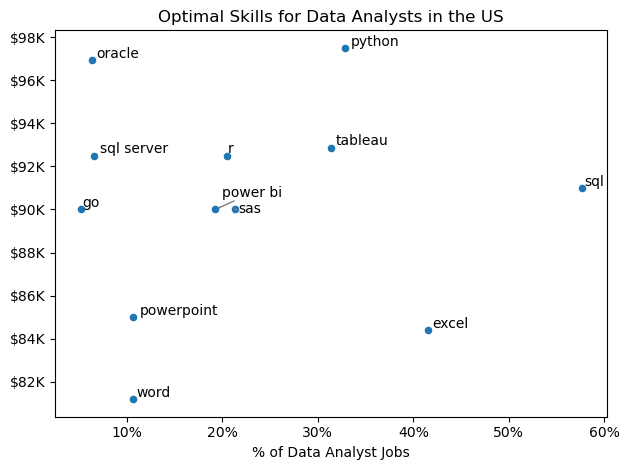

In [32]:
from adjustText import adjust_text

df_DA_US_skills_high_demand.plot(
    kind = 'scatter',
    x = 'skill_percent',
    y = 'median_salary'
)

texts = []
for i, txt in enumerate(df_DA_US_skills_high_demand.index):
    texts.append(plt.text(df_DA_US_skills_high_demand['skill_percent'].iloc[i], df_DA_US_skills_high_demand['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'gray'))

plt.xlabel('% of Data Analyst Jobs')
plt.ylabel('')
plt.title('Optimal Skills for Data Analysts in the US')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(decimals = 0))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

plt.tight_layout()
plt.show()

In [33]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [41]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns = ['technology', 'skills'])
df_technology = df_technology.explode('skills')

In [43]:
df_plot = df_DA_US_skills_high_demand.merge(df_technology, left_on = 'job_skills', right_on = 'skills')

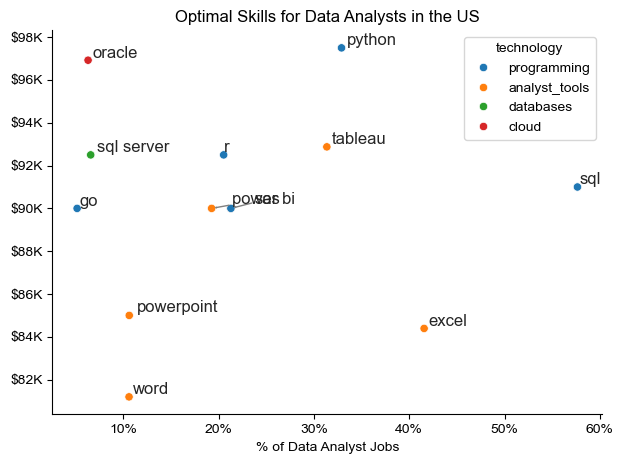

In [47]:
from adjustText import adjust_text

sns.scatterplot(
    data = df_plot,
    x = 'skill_percent',
    y = 'median_salary',
    hue = 'technology'
)

sns.despine()
sns.set_theme(style = 'ticks')

texts = []
for i, txt in enumerate(df_DA_US_skills_high_demand.index):
    texts.append(plt.text(df_DA_US_skills_high_demand['skill_percent'].iloc[i], df_DA_US_skills_high_demand['median_salary'].iloc[i], txt))

adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'gray'))

plt.xlabel('% of Data Analyst Jobs')
plt.ylabel('')
plt.title('Optimal Skills for Data Analysts in the US')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(decimals = 0))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))

plt.tight_layout()
plt.show()